In [1]:
#visualisation of class activation(o/p) map (CAM) 
#produces heat maps of class activation over i/p images => which part of a given image
#lead a convnet to its final classification decision
from keras.applications.vgg16 import VGG16                           #loading the vgg16 pretrained cnn model
model = VGG16(weights='imagenet')

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = '/home/anish/Documents/Jupyter Notebook/SA-DLwithPy/CatsVsDogs/creative_commons_elephant.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)                                             #float32 Numpy array of shape (224,224,3)

x = np.expand_dims(x, axis=0)                                           #adds a dimension (like a batch) (1,224,224,3)

x = preprocess_input(x)                                                 #preporocess the input the way vgg16 network accepts the i/p images

#running the vgg16 network with this image as iput and asking for its prediction
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Using TensorFlow backend.




('Predicted:', [(u'n02504458', u'African_elephant', 0.909421), (u'n01871265', u'tusker', 0.086182885), (u'n02504013', u'Indian_elephant', 0.0043545826)])


In [2]:
print preds.shape                                                       #prediction vector is a 1000 element vector 
np.argmax(preds)                                                        #to check which index corresponds to the african ele, we check for index corresponding to the maximum probability in the prediction vector

(1, 1000)


386

In [16]:
model.output.shape

TensorShape([Dimension(None), Dimension(1000)])

In [3]:
#To visualise which parts of the image are more african elephant like we use - Grad-CAM algorithm
#this is done by calculating the gradient of the class(the ground truth) with respect to the channels in the o/p feature map(generated by a given i/p image) of a conv layer
from keras import backend as K
african_elephant_output = model.output[:, 386]                            #the index 386 correspods to the africanelephant class in the actual o/P vector of the model, the ground truth 

last_conv_layer = model.get_layer('block5_conv3')                         #selects the last conv layer

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]   #calculating grad of class africanelephant wrt lastconvlayer o/p feature maps
print grads.shape                                                         

pooled_grads = K.mean(grads, axis=(0, 1, 2))                              #calculating mean along first 3 axises except last one , this gives an info how imp each of the 512 channel is wrt the specific class
print pooled_grads.shape

(?, 14, 14, 512)
(512,)


In [4]:
#using a function which takes an image i/p and gives o/p pooledgrads and last conv layer o/p defined above
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])           

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):                                                      #multiplies each channel in the featuremap array by how imp this channel is wrt the africanelephant class
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)                       #shape is 14x14x512 taking mean of axis=-1 returns a mean along axis of 512 channels and result is of shape 14x14
heatmap.shape

(14, 14)

(14, 14)

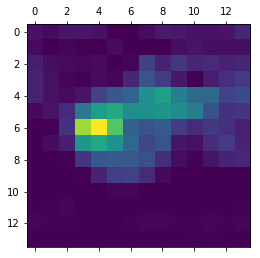

In [6]:
#normalising the heatmap and plotting the same
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)                                         #removing all -ve values
heatmap /= np.max(heatmap)                                               #normalising by dividing heatmap by its maximum value
plt.matshow(heatmap)
heatmap.shape


In [15]:
#using OpenCV to generate an image taht superimposes the original image on the heatmap obtained
import cv2
img = cv2.imread(img_path)                                                   #load the image using opencv
print img.shape
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))                  #resizes the heatmap to the same size of the original image
heatmap = np.uint8(255 * heatmap)                                            #converting the normalised heatmap to RGB
print heatmap.shape                                                          #we can see the heatmap has same shape of the image

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)                       #converts wxh from of heatmap to a 2d tensor adding a depth /channel so as to be an exact rgb image
print heatmap.shape

superimposed_img = heatmap * 0.4 + img                                       #0.4 is a heatmap intensity factor

cv2.imwrite('/home/anish/Documents/Jupyter Notebook/SA-DLwithPy/CatsVsDogs/elephant_cam.jpg', superimposed_img)

(600, 899, 3)
(600, 899, 3)
(600, 899, 3)


True

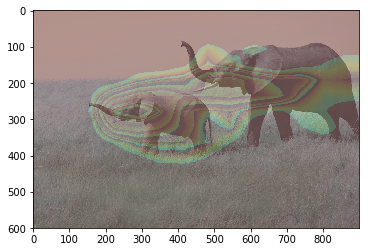

In [13]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)                                          #vlaues<0 will be set to zero and values>0 will be set to one
    x *= 255
    x = np.clip(x, 0, 255).astype('int32')                        #converts into an rgb array
    return x
processed_img = deprocess_image(superimposed_img)
plt.imshow(processed_img)